# CVaR Calculation

Conditional Value at Ristk (CVaR) is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has. It is derived by taking a weighted average of the "extreme" losses in the tail of the distribution of returns, beyond the VaR cutoff point. 

See @ [Conditional Value at Risk](https://www.investopedia.com/terms/c/conditional_value_at_risk.asp)

In [4]:
# import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

## Formula

The formula for CVaR is given by:
$$\begin{equation}
\mathrm{CVaR} = \dfrac{1}{(1-c)} \int_{-1}^{\mathrm{VaR}} xp(x)\ \mathrm{d}x,

\tag{\text{CVaR}}
\end{equation}$$
where:
- $p(x)\ \mathrm{d}x$ is the probability density of getting a return with value $x$
- $c$ is the cur-off on the distribution where the analyst sets the $\mathrm{VaR}$ breakpoint.
- $\mathrm{VaR}$ is the agreed-upon value at risk level.

## Data Collection

In [9]:
# get data
def getData(ticker, start, end):
    data = yf.download(ticker, start=start, end=end);
    data = data["Close"]
    returns = data.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [11]:
# portfolio performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns * weights) * Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

In [27]:
# Preparation
stocks = ["BRK-B", "AAPL", "RITM", "JPM", "MSFT", "W", "DPZ", "MIDD"]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365)

returns, meanReturns, covMatrix = getData(stocks, startDate, endDate)
returns = returns.dropna()

[*********************100%***********************]  8 of 8 completed


In [28]:
## Question: how to decide the weights?
weights = [0.139, 0.106, 0.049, 0.120, 0.128, 0.066, 0.038, 0.043]
# weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns["portfolio"] = returns.dot(weights)

## Monte Carlo Simulation

There are many ways to calculate the CVaR. One of the most popular methods is the Monte Carlo simulation. This method involves generating a large number of random samples from the distribution of returns and then calculating the average of the worst $1-c$ percent of the returns.

See other methods @ [Value at Risk (VaR) and Conditional VaR (CVaR)](https://quantpy.com.au/risk-management/value-at-risk-var-and-conditional-var-cvar/)

In [29]:
# Monte Carlo
mc_sims = 10000 # number of simulations
T = 365       # number of trading days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 100000

for m in range(0, mc_sims):
    # Monte Carlo main loop
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio

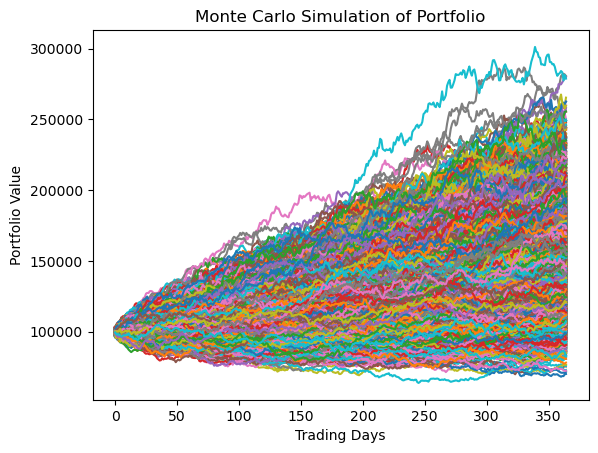

In [30]:
# Plotting part
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value")
plt.xlabel("Trading Days")
plt.title("Monte Carlo Simulation of Portfolio")
plt.show()

In [31]:
# Calculate the VaR and CVaR
def mcVaR(returns, alpha=5):
    """
    Args:
        returns (panda series): daily returns of the portfolio
        alpha (int): significance level
        
    Returns:
        float: conditional value at risk
    """
    
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else: 
        raise TypeError("Expected returns to be a pandas series")


# Use mcVaR to calculate the VaR and CVaR
def mcCVaR(returns, alpha=5):
    """
    Args:
        returns (panda series): daily returns of the portfolio
        alpha (int): significance level
    
    Returns:
        float: conditional value at risk
    """
    
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha)
        return returns[belowVaR].mean()
    else: 
        raise TypeError("Expected returns to be a pandas series")

In [32]:
portResults = pd.Series(portfolio_sims[-1, :])

VaR = initialPortfolio - np.percentile(portResults, 5)
CVaR = initialPortfolio - mcCVaR(portResults, 5)

print(f"Value at Risk: {VaR}")
print(f"Conditional Value at Risk: {CVaR}")

Value at Risk: -6228.232462850836
Conditional Value at Risk: 1331.0540535816253
